# 多GPU训练

将问题分散到多个GPU上，例如每个GPU计算16个通道的数据，而非一个GPU计算64通道

K个GPU进行数据并行实验：
   * 将随机小批量分成k份，均匀的分配到k个GPU上
   * 每个GPU根据分得的数据计算模型参数的损失和梯度
   * 将k个GPU的梯度进行聚合，获得当前小批量的随机梯度
   * 聚合梯度重新分配到每个GPU中
   * 每个GPU使用这个小批量随机梯度，来更近它所维护的完整的模型参数集

In [2]:
!pip install d2l

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/6a/be/eb453dbdd80d0563e2a6dac4aff8b76b0c24641d20b05e85b560f90282f9/d2l-0.17.5-py3-none-any.whl (82 kB)


In [3]:
import sys 
sys.path.append("../")
import lmy

In [4]:
#matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

## 利用Lenet进行训练学习

In [5]:
scale = .01
W1 = torch.randn((20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn((50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn((800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn((128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]


def lenet(X, params):
    h1_covn = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_covn)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))

    h2_covn = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_covn)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat


loss = nn.CrossEntropyLoss(reduction='none')

### 数据同步

对于高效的多GPU训练，我们需要两个基本操作。
* 需要向多设备发参数并附加梯度（get_params),如果没有参数，我们就不可能再GPU上进行网络评估。
* 需要跨多设备对参数求和(allreduce) 

In [6]:
def get_params(params,device):
    """将参数分发到不同的设备中"""
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params
devices,_ = lmy.getGPU(1,False)
new_params = get_params(params,devices[0])

In [7]:
print(new_params[1])
print(new_params[1].grad)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
None


假设现在有一个向量分布在多个GPU上，需要通过allreduce函数将所有的向量相加，并将结果广播给所有的GPU。我们需要将数据复制到累计结果的设备，才能使函数正常工作

In [8]:
def allreduce(data):
    # 将所有数据拷贝到第一个设备
    for i in range(1,len(data)):
        data[0][:] += data[i].to(data[0].device)
    
    # 将第一个设备的数据拷贝到所有的设备
    for i in range(1,len(data)):
        data[i][:] = data[0].to(data[i].device)
    return data

In [9]:
data = [torch.ones((1,2),device=devices[i]) *(i+1) for i in range(2)]
print("allreduce之前:\n",data[0],"\n",data[1])
data = allreduce(data)
print("allreduce之后:\n",data[0],"\n",data[1])

allreduce之前:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


### 数据分发

In [10]:
data = torch.arange(20).reshape(4,5)
data

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])

In [11]:
split_data = nn.parallel.scatter(data,devices)
split_data

(tensor([[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]], device='cuda:0'),
 tensor([[10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]], device='cuda:1'))

In [12]:
def split_batch(X,y,devices):
    """将数据和标签拆分到多个设备上"""
    assert X.shape[0] == y.shape[0],"数据与标签行数不一致"
    return (nn.parallel.scatter(X,devices),
            nn.parallel.scatter(y,devices))
        

### 训练

In [13]:
def train_batch(X, y, device_params, devices, lr):  #shard碎片
    X_shards, y_shards = split_batch(X, y, devices)

    # 分别在每个GPU上计算损失
    ls = [loss(lenet(X_shard, devices_W), y_shard).sum()  # devices_W指单GPU上的参数
          for X_shard, y_shard, devices_W in zip(X_shards, y_shards, device_params)]

    # 在每个GPU上分别执行反向传播
    for l in ls:
        l.backward()

    # 将每个GPU的所有梯度相加，并将其广播
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))]
            )
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        lmy.sgd1(param, lr, X.shape[0])

定义训练函数，训练函数需要分配GPU并将所有的模型参数复制到所有的设备，显然，每个小批量都是使用train_batch函数来处理多个GPU.
我们只在一个GPU上计算模型的精确度，而让其他GPU保持空闲

In [18]:
from d2l import torch as d2l

NameError: name 'device' is not defined

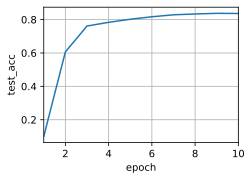

In [19]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = lmy.loadFashionMnistData(batch_size,root='../lmy/data')
    devices, _ = lmy.getGPU(1)
    devices = devices[:num_gpus]
    # 将模型复制到所有的GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test_acc', xlim=[1, num_epochs])
    timer = lmy.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量进行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()

        #在GPU0上进行评估
        animator.add(epoch + 1,
                     (d2l.evaluate_accuracy_gpu(lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f"测试精度：{animator.Y[0][-1]:.2f},{timer.avg():.1f}秒/轮，在{str(device)}上")


train(num_gpus=1, batch_size=256, lr=.2)

In [3]:
import torch
from torch import nn
import sys

sys.path.append("../")
import lmy
import d2l


def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""

    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(
        64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net


def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = lmy.loadFashionMnistData(batch_size, "../lmy/data")
    devices, _ = lmy.getGPU(1)
    devices = devices[:num_gpus]
    assert devices is None,"None of GPU"
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = lmy.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')


def main():
    net = resnet18(10)
    timer1 = lmy.Timer("1")
    timer2 = lmy.Timer("1")

    with timer1:
        train(net, num_gpus=1, batch_size=256, lr=0.1)
    with timer2:
        train(net, num_gpus=2, batch_size=512, lr=0.2)


main()

数据集加载成功 60000 10000
1 has run for 0.0326s


AssertionError: None of GPU